# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
Обучите модель классифицировать комментарии на позитивные и негативные. 

В вашем распоряжении набор данных с разметкой о токсичности правок.
Постройте модель со значением метрики качества F1 не меньше 0.75. 

## Описание данных

Данные находятся в файле /datasets/toxic_comments.csv.

Столбец text в нём содержит текст комментария, а toxic — целевой признак.

## План работы

#### Шаг 1. Загрузка данных
Загрузим датафрейм с данными `car_df`, изучим состав и качество датафрейма.

#### Шаг 2. Предобработка и подготовка данных
Изучим данные, при необходимости выполним предобработку. Кроме того, токенизируем и лемматизируем тексты.

#### Шаг 3. Обучение моделей
Обучим модель логистической регрессии, CatBoostRegressor, Naive Bayes, оценим их работу с помощью метрики F1. По необходимости подберем дополнительную метрику.

#### Шаг 4. Выберем лучшую модель
Учитывая требования Заказчика, отберем модель, которая лучше всего подойдет для решения задачи

#### Шаг 5. Выводы по проекту
Cоберем промежуточные выводы, а затем дадим общие выводы по всему проекту.

In [1]:
!pip install contractions

zsh:1: /usr/local/bin/pip: bad interpreter: /System/Library/Frameworks/Python.framework/Versions/2.7/Resources/Python.app/Contents/MacOS/Python: no such file or directory
Defaulting to user installation because normal site-packages is not writeable
    scipy (>=1.0matplotlib>=3.1)
          ~~~~~~^
    matplotlib-inline (<0.2.0appnope,>=0.1.0) ; platform_system == "Darwin"
                      ~~~~~~~~^


In [2]:
import os
import contractions
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm, notebook
from sklearn.pipeline import make_pipeline
import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, f1_score, roc_auc_score, classification_report
from joblib import parallel_backend
from sklearn.utils import parallel_backend, resample

from sklearn.model_selection import (cross_val_score, 
                                     train_test_split, KFold, 
                                     cross_val_predict, GridSearchCV, 
                                     TimeSeriesSplit)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_colwidth', None)

In [3]:
TEST_SIZE = 0.1
RANDOM_STATE=42

In [4]:
import re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm.notebook import tqdm

from nltk import pos_tag
from urllib.request import urlretrieve
import ssl
# Отключение проверки SSL-сертификатов для загрузки данных NLTK
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/macbookpro/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
#функция для вывода первичной информации
def quick_info(df):
    df.info()
    print(df.describe())
    print('Дубликаты:', df.duplicated().sum())

### Шаг 1. Загрузка данных

In [6]:
pth1 = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'
pth2 = '/Users/macbookpro/Downloads/toxic_comments.csv'

if os.path.exists(pth2):
    comms_df = pd.read_csv(pth2, index_col=0) 
else:
    try:
        urlretrieve(pth1)
        comms_df = pd.read_csv(pth2, index_col=0)
    except Exception as e:
        print('Something is wrong:', e)

In [7]:
quick_info(comms_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
               toxic
count  159292.000000
mean        0.101612
std         0.302139
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Дубликаты: 0


В датафрейме 159292 строки и две колонки, целевой признак - toxic. Явных дубликатов не видим, как и пробелов или NaN-значений. Посмотрим, какая доля текстов каждой категории от общего числа: 

In [8]:
display(comms_df['toxic'].value_counts())
#Выведем соотношение
tox_ratio = comms_df['toxic'].value_counts()[0] / comms_df['toxic'].value_counts()[1]
tox_ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

Видим, что нетоксичных текстов (значения с параметром 0) в 8.8 раза больше, чем токсичных. Это значит, что нужно будет сбалансировать классы, чтобы улучшить предсказания модели. Проведем балансировку после токенизации текстов: так точно не упустим потенциально важную информацию при балансировке (например, если будем использовать undersampling). 

#### Выводы

- В датафрейме 159292 строки и две колонки, целевой признак - toxic
- Явных дубликатов не видим, как и пробелов или NaN-значений
- Нетоксичных текстов (значения с параметром 0) в датафрейме в 8.8 раза больше, чем токсичных

### Шаг 2. Предобработка и подготовка данных

Перейдем к токенизации и лемматизации текста. Так как мы видим, что твиты у нас англоязычные, Mystem не подойдет: он заточен Яндексом изначально на русский язык. Жаль, кстати, что в Практикуме толком нет про другие инструменты лемматизации(

Мы же возьмем распространенный инструмент для лемматизации WordNetLemmatizer из nltk, для токенизации word_tokenize: они подходят для большинства задач и работают в том числе с английским. 

In [9]:
lemmatizer = WordNetLemmatizer()

def get_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN 

def clean_text(text):
    expanded_text = contractions.fix(text)
    clean = " ".join(re.sub(r'[^a-zA-Z\s]', ' ', expanded_text).lower().split())
    word_list = nltk.word_tokenize(clean)
    pos_tags = pos_tag(word_list)
    
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w, get_pos(tag)) for w, tag in pos_tags])
    return lemmatized_output

tqdm.pandas()
comms_df['lemm_text'] = comms_df['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [10]:
comms_df.head(10)

,text,toxic,lemm_text
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits make under my username hardcore metallica fan be revert they be not vandalisms just closure on some gas after i vote at new york doll fac and please do not remove the template from the talk page since i be retire now
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he match this background colour i be seemingly stick with thanks talk january utc
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i be really not try to edit war it be just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the formatting than the actual info
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can not make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it be list in the relevant form eg wikipedia good article nomination transport
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir be my hero any chance you remember what page that be on
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,congratulation from me a well use the tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,your vandalism to the matt shirvington article have be revert please do not do it again or you will be ban
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,sorry if the word nonsense be offensive to you anyway i be not intend to write anything in the article wow they would jump on me for vandalism i be merely request that it be more encyclopedic so one can use it for school a a reference i have be to the selective breeding page but it be almost a stub it point to animal breeding which be a short messy article that give you no info there must be someone around with expertise in eugenics
9,alignment on this subject and which are contrary to those of DuLithgow,

Посмотрим, были ли токенизированы все строки, с помощью проверки на пустые строки:

In [11]:
total_rows = len(comms_df)
lemmatized_rows = comms_df['lemm_text'].notna().sum()

print(f'Всего строк: {total_rows}')
print(f'Лемматизировано и токенизировано строк: {lemmatized_rows}')

Всего строк: 159292
Лемматизировано и токенизировано строк: 159292


Далее разобьем датасет на тестовую и тренировочную выборки. Валидационную отдельно создавать не буду, так как для промежуточной оценки будем использовать параметры из кросс-валидации.

In [12]:
comms_df = comms_df.drop(['text'], axis=1)

X = comms_df['lemm_text']
y = comms_df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

print('Размерность X_train:', X_train.shape)
print('Размерность X_test:', X_test.shape)
print('Размерность y_train:', y_train.shape)
print('Размерность y_test:', y_test.shape)

Размерность X_train: (143362,)
Размерность X_test: (15930,)
Размерность y_train: (143362,)
Размерность y_test: (15930,)


#### Выводы

- Лемматизировали и токенизировали тексты из датасейта с помощью WordNetLemmatizer из nltk
- Проверили, были ли токенизированы все строки, с помощью проверки на пустые строки
- Разбили датасет на тестовую и тренировочную выборки. Валидационную делать не стали, так как для промежуточной оценки будем использовать кросс-валидацию.
- Не стали балансировать классы: будем использовать модели, которые можно настроить на работу с несбалансированными классами.

### Шаг 3. Обучение моделей

В этом проекте будем использовать кросс-валидацию, а для поиска параметров - поиск по сетке GridSearchCV. В качестве метрик возьмем контрольную F1 (условия проекта) и добавим к ней ROC AUC, чтобы понимать, насколько в целом хорошо модели различают классы.

До этого пропишем условия, одинаковые для всех моделей: число фолдов и метрики для оценки. Далее упакуем все модели в пайплайны, в них же добавим векторизацию. 

In [19]:
cv_counts = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    'F1': make_scorer(f1_score),
    'ROC AUC': make_scorer(roc_auc_score, needs_proba=True)
}

Далее пропишем гиперпараметры для сетки и создадим один общий пайплайн: 

Создадим функцию, которая поможет вывести прогресс-бар по нашему пайплайну:

C помощью пайплайна векторизуем данные с TfidfVectorizer и обучим три модели: логистическую регрессию, RandomForest и LGBM Classifier. Также масштабируем данные, чтобы модели, особенно логистические регрессия, сходились быстрее. Посмотрим результаты по тренировочным данным, на F1 по кросс-валидации:

In [20]:
warnings.filterwarnings('ignore', category=ConvergenceWarning)

base_pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'),
    StandardScaler(with_mean=False)
)

models = {
    'logistic_regression': LogisticRegression(max_iter=1000, 
                                              solver='saga', class_weight='balanced', n_jobs=-1),
    'lgbm': LGBMClassifier(),
    'random_forest': RandomForestClassifier(n_jobs=-1)
}

# Гиперпараметры
param_grids = {
    'logistic_regression': {
        'logisticregression__penalty': ['l2'],
        'logisticregression__C': [15],
    },
    'lgbm': {
        'lgbmclassifier__n_estimators': [100, 200],
        'lgbmclassifier__max_depth': [20],
        'lgbmclassifier__learning_rate': [0.5],
        'lgbmclassifier__class_weight': ['balanced']
    },
    'random_forest': {
        'randomforestclassifier__n_estimators': [100],
        'randomforestclassifier__max_depth': [30],
        'randomforestclassifier__class_weight': ['balanced']
    }
}

best_models = {}
for model_name, model in tqdm(models.items(), desc='Статус по моделям'):
    pipeline = make_pipeline(base_pipeline, model)
    
    grid_search = GridSearchCV(
        pipeline,
        param_grids[model_name],
        scoring='f1',
        cv=3,
        verbose=1,
    )
    
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    
    print(f'Лучшие параметры для {model_name}:', grid_search.best_params_)
    print(f'Лучший F1 Score на кросс-валидации для {model_name}:', round(grid_search.best_score_, 2))

Статус по моделям:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Лучшие параметры для logistic_regression: {'logisticregression__C': 15, 'logisticregression__penalty': 'l2'}
Лучший F1 Score на кросс-валидации для logistic_regression: 0.69
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Лучшие параметры для lgbm: {'lgbmclassifier__class_weight': 'balanced', 'lgbmclassifier__learning_rate': 0.5, 'lgbmclassifier__max_depth': 20, 'lgbmclassifier__n_estimators': 200}
Лучший F1 Score на кросс-валидации для lgbm: 0.76
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Лучшие параметры для random_forest: {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__n_estimators': 100}
Лучший F1 Score на кросс-валидации для random_forest: 0.43


Видим, что лучше всего себя показываем LGBM: попробуем визуализировать распределение ошибок:

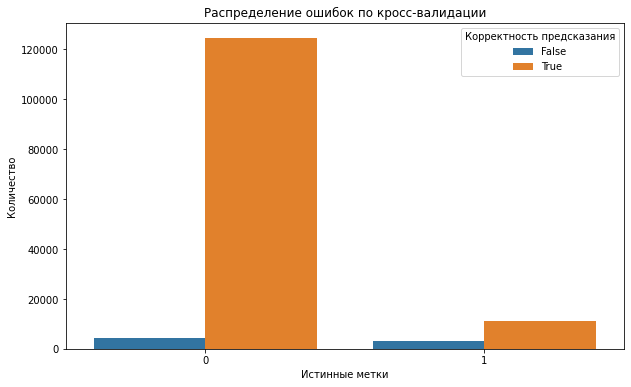

In [21]:
y_pred_cv = cross_val_predict(best_models['lgbm'], X_train,
                              y_train, cv=cv_counts, method='predict')

errors_df_model = pd.DataFrame({
    'True': y_train,
    'Predicted': y_pred_cv,
    'Correct': y_train == y_pred_cv
})

plt.figure(figsize=(10, 6))
sns.countplot(x='True', hue='Correct', data=errors_df_model)
plt.title('Распределение ошибок по кросс-валидации')
plt.xlabel('Истинные метки')
plt.ylabel('Количество')
plt.legend(title='Корректность предсказания')
plt.show()

#### Выводы

- C помощью пайплайна векторизовали данные с TfidfVectorizer
- обучили три модели: логистическую регрессию, RandomForest и LGBM Classifier. 
- Также масштабировали данные, чтобы модели, особенно логистические регрессия, сходились быстрее.

### Шаг 4. Выбираем лучшую модель

Ранее лучше всего в рамках наших условий себя показала LGBM. Теперь обучим ее лучшую версию на тестовых данных и посмотрим на результаты метрик:

In [22]:
predictions_final = best_models['lgbm'].predict(X_test)

# Вычисление F1-метрики
final_f1 = f1_score(y_test, predictions_final)
print('Финальная F1-метрика для лучшей модели:', round(final_f1, 2))

Финальная F1-метрика для лучшей модели: 0.77


Модель проходит по критерию, который выставил заказчик. Проверим распределение ошибок и заодно построим матрицу ошибок:

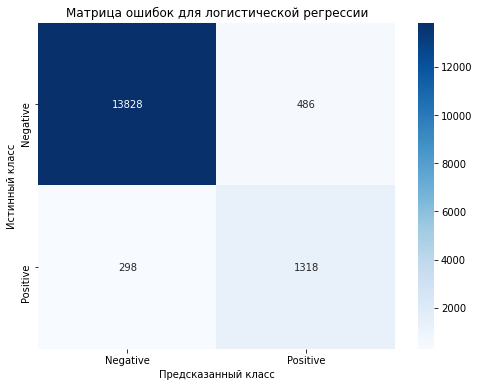

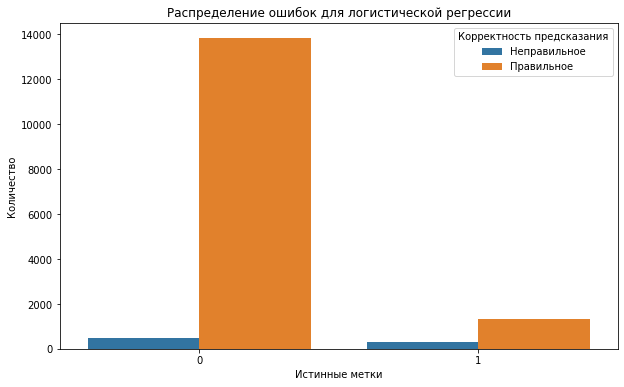

In [23]:
cm = confusion_matrix(y_test, predictions_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок для логистической регрессии')
plt.show()

errors_df = pd.DataFrame({
    'True': y_test,
    'Predicted': predictions_final
})

errors_df['Correct'] = errors_df['True'] == errors_df['Predicted']

plt.figure(figsize=(10, 6))
sns.countplot(x='True', hue='Correct', data=errors_df)
plt.title('Распределение ошибок для логистической регрессии')
plt.xlabel('Истинные метки')
plt.ylabel('Количество')
plt.legend(title='Корректность предсказания', labels=['Неправильное', 'Правильное'])
plt.show()

Мы видим, что модель относительно часто ложно предсказывает негативные значения как положительные, то есть много ложно положительных значений. Это может быть связано с несколькими причинами:
    
- Недостаточный порог для классификации (или наоборот, избыточный)
- Недостатки токенизации

Тем не менее, финальная F1-метрика проходит пороговое контрольное значение, поэтому в рамках этого проекта пока остановлюсь на ней.

### Шаг 5. Общие выводы

При выполнении проекта проделана следующая работа:

**На первом этапе произведена загрузка данных и их подготовка для обучения моделей**

- В датафрейме 159292 строки и две колонки, целевой признак - toxic
- Явных дубликатов не видим, как и пробелов или NaN-значений
- Нетоксичных текстов (значения с параметром 0) в датафрейме в 8.8 раза больше, чем токсичных

**Далее обработали данные:**

- Лемматизировали и токенизировали тексты из датасейта с помощью WordNetLemmatizer из nltk
- Проверили, были ли токенизированы все строки, с помощью проверки на пустые строки
- Разбили датасет на тестовую и тренировочную выборки. Валидационную делать не стали, так как для промежуточной оценки будем использовать кросс-валидацию.


**Следующим этапом обучили модели:**

- C помощью пайплайна векторизовали данные с TfidfVectorizer
- обучили три модели: логистическую регрессию, RandomForest и LGBM Classifier. 
- Также масштабировали данные, чтобы модели, особенно логистические регрессия, сходились быстрее.

В результате остановились на LGBM как лучшей модели: взяли лучшую ее версию по GridSearch и сделали предсказания уже по финальной выборке. 

Мы видим, что модель относительно часто ложно предсказывает негативные значения как положительные, то есть много ложно положительных значений. Это может быть связано с несколькими причинами:
    
- Недостаточный порог для классификации (или наоборот, избыточный)

- Недостатки токенизации.
